<a href="https://colab.research.google.com/github/mchirico/colab/blob/master/libUseLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!curl -s https://course.fast.ai/setup/colab | bash
!pip install fire


from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate



Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

In [0]:
!ln -s '/content/gdrive/My Drive/Colab Notebooks/exp/' exp

In [49]:
!ls exp

nb_devLibFastAI.py  __pycache__


In [0]:
from exp.nb_devLibFastAI import *

In [51]:
path = datasets.download_data(MNIST_URL,ext='.gz');path

PosixPath('/content/data/mnist.pkl.gz')

In [0]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')


In [53]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [54]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [0]:
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
img = x_train[0]

In [58]:
img.view(28,28).type()

'torch.FloatTensor'

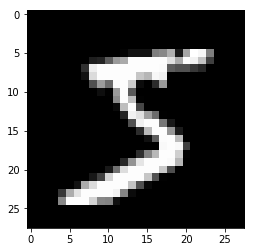

In [59]:
plt.imshow(img.view((28,28)));

**Initial python model**

In [0]:
weights = torch.randn(784,10)

In [0]:
bias = torch.zeros(10)

##[Matrix multiplication](http://matrixmultiplication.xyz/)

In [0]:
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

In [0]:
m1 = x_valid[:150]
m2 = weights

In [64]:
m1.shape,m2.shape

(torch.Size([150, 784]), torch.Size([784, 10]))

In [65]:
%time t1=matmul(m1, m2)

CPU times: user 20.8 s, sys: 6.45 ms, total: 20.8 s
Wall time: 20.8 s


###Elementwise ops

Operators (+,-,*,/,>,<,==)  are usually element-wise.

Examples of element-wise operations:

In [66]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [67]:
a + b

tensor([12., 14.,  3.])

In [68]:
(a < b).float().mean()

tensor(0.6667)

In [69]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [71]:
%time t1=matmul(m1, m2)

CPU times: user 35.3 ms, sys: 951 µs, total: 36.2 ms
Wall time: 38.8 ms


In [72]:
m1 = x_valid[:50000]
m2 = weights
%time t1=matmul(m1, m2)

CPU times: user 2.04 s, sys: 85 ms, total: 2.12 s
Wall time: 2.12 s


### Broadcasting

In [73]:
a

tensor([10.,  6., -4.])

In [74]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [75]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

In [0]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
        c[i]   = (a[i  ].unsqueeze(-1) * b).sum(dim=0)
    return c

In [77]:
m1 = x_valid[:50000]
m2 = weights
%time t1=matmul(m1, m2)

CPU times: user 428 ms, sys: 7.02 ms, total: 435 ms
Wall time: 440 ms


This following was done with GPU



```
CPU times: user 423 ms, sys: 6.95 ms, total: 430 ms
Wall time: 432 ms
```

The following was done with TPU (Seems slower)

```
CPU times: user 504 ms, sys: 11.9 ms, total: 515 ms
Wall time: 522 ms
```

